In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score,cross_val_predict
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix,log_loss
import warnings

In [2]:
# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
# Load sheets into DataFrames
Main_data = pd.read_excel("C:\\Users\\Mukaffi\\Downloads\\Preprocessed_Main_data.xlsx")

In [4]:
Main_data.head()

,device,time,Temperature Sensor-1,Vibration Sensor-1,Vibration Sensor-2,Vibration Sensor-3,Health
0,esp32_001,09:34:57,20.797449,2147483647,4758,2147483647,Bad
1,esp32_001,09:35:03,21.683039,7056,4590,2147483647,Bad
2,esp32_001,09:35:08,21.838221,4465,6405,2147483647,Bad
3,esp32_001,09:35:14,21.855524,3699,935,2147483647,Bad
4,esp32_001,09:35:19,21.700251,2269,266,447,Moderate


In [5]:
Main_data.shape

(20505, 7)

In [6]:
Main_data['Health'].unique()

array(['Bad', 'Moderate', 'Good'], dtype=object)

In [7]:
Main_data['Health'].value_counts()

Health
Good        8066
Moderate    8051
Bad         4388
Name: count, dtype: int64

In [8]:
Main_data['device'].value_counts()

device
Rittou_57    16813
esp32_001     3692
Name: count, dtype: int64

# ***Distribution of Health Categories***

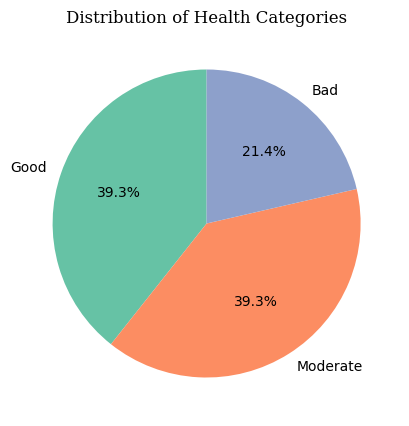

In [9]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
custom_palette = ['Purple', 'MediumVioletRed', 'lightcoral', 'Dodgerblue', 'Dodgerblue', 'Purple']
# Define a custom font
custom_font = FontProperties(family='serif', style='normal', size=12)

plt.figure(figsize=(8, 5))

# Create a pie chart for the 'Health' column
health_counts = Main_data['Health'].value_counts()
labels = health_counts.index
sizes = health_counts.values
colors = sns.color_palette("Set2")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)

plt.title('Distribution of Health Categories', fontproperties=custom_font)

plt.show()


# ***Convert categorical labels to numerical using LabelEncoder***

In [10]:
# Drop Column Device, time and Health 
X = Main_data.drop(columns=['device','Health','time'])
y = Main_data['Health']

# Convert categorical labels to numerical using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Get the original class labels
original_classes = label_encoder.classes_
original_classes

array(['Bad', 'Good', 'Moderate'], dtype=object)

In [11]:
X.shape

(20505, 4)

In [12]:
X.corr()

,Temperature Sensor-1,Vibration Sensor-1,Vibration Sensor-2,Vibration Sensor-3
Temperature Sensor-1,1.000000,-0.002077,-0.004496,-0.038567
Vibration Sensor-1,-0.002077,1.000000,-0.000188,0.054852
Vibration Sensor-2,-0.004496,-0.000188,1.000000,0.070827
Vibration Sensor-3,-0.038567,0.054852,0.070827,1.000000


# ***Apply Normalization***

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features in X
X_normalized = scaler.fit_transform(X)

X_normalized

array([[1.01043681e-01, 1.00000000e+00, 2.20118094e-06, 1.00000000e+00],
       [1.04151014e-01, 3.24193403e-06, 2.12294984e-06, 1.00000000e+00],
       [1.04695512e-01, 2.03540558e-06, 2.96812509e-06, 1.00000000e+00],
       ...,
       [1.12036435e-01, 3.68151830e-06, 3.08454041e-06, 1.41374769e-06],
       [1.08068933e-01, 7.35744866e-08, 2.15042386e-06, 2.76509677e-06],
       [1.05913000e-01, 2.53878545e-06, 7.17118393e-08, 8.84756459e-08]])

# ***Train and Test Split with stratified sampling***

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
X_train.shape

(16404, 4)

In [16]:
X_test.shape

(4101, 4)

# ***Apply SMOTE on Train dataset for Handle Imbalanced Dataset***

In [17]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit and apply SMOTE only on the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution
print("Original class distribution:", {label: count for label, count in zip(*np.unique(y_train, return_counts=True))})
print("Resampled class distribution:", {label: count for label, count in zip(*np.unique(y_train_resampled, return_counts=True))})

Original class distribution: {0: 3510, 1: 6453, 2: 6441}
Resampled class distribution: {0: 6453, 1: 6453, 2: 6453}


In [19]:
import lightgbm as lgbm
LightGBM_Classifier = lgbm.LGBMClassifier()

In [20]:
LightGBM_Classifier.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 19359, number of used features: 4
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


LGBMClassifier()

In [21]:
# Evaluate the model
predictions = LightGBM_Classifier.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       878
           1       1.00      1.00      1.00      1613
           2       0.99      0.99      0.99      1610

    accuracy                           0.99      4101
   macro avg       0.99      0.99      0.99      4101
weighted avg       0.99      0.99      0.99      4101



In [22]:
predicted_proba = np.zeros((len(y_test), 3)) 
predicted_proba[np.arange(len(y_test)), predictions] = 1

log_loss_value = log_loss(y_test, predicted_proba)
print(f"Log Loss: {log_loss_value}")

Log Loss: 0.3076146960787862


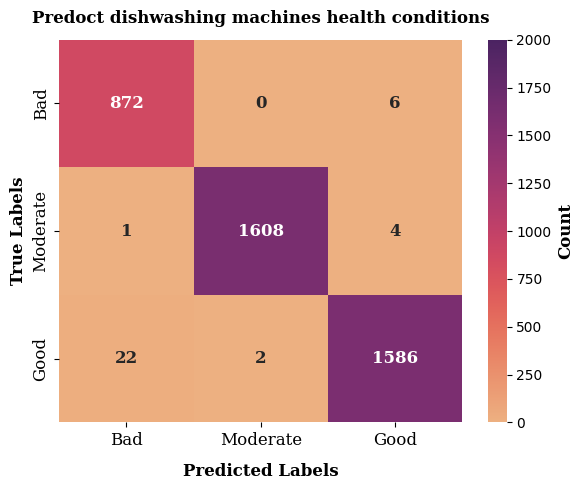

In [26]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
# Define the custom palette
custom_palette = sns.color_palette("flare", as_cmap=True) # Modify the number based on number of classes in the dataset
# Define custom font dictionary for title and labels
font = {'family': 'Serif', 'weight': 'bold', 'size': 12}

# Create heatmap with annotations and colormap
heatmap = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=custom_palette,vmin=0,vmax=2000,
                      xticklabels=['Bad', 'Moderate', 'Good'], yticklabels=['Bad', 'Moderate', 'Good'],annot_kws={"family": "Serif",'weight': 'bold', 'size': 12})

# Set x and y labels with the custom font dictionary
heatmap.set_xlabel('Predicted Labels', fontdict=font)
heatmap.set_ylabel('True Labels', fontdict=font)
heatmap.set_title('Predoct dishwashing machines health conditions', fontdict=font, pad=12)

# Set font properties for tick labels on both axes
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontname='Serif', fontsize=12)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontname='Serif', fontsize=12)

# Create a color bar to indicate the scale
cbar = heatmap.collections[0].colorbar
cbar.set_label('Count', fontdict=font)
cbar.ax.tick_params(labelsize=10)
# Adjust padding between x-axis label and x-axis ticks
plt.gca().xaxis.labelpad = 10  # Change the value as needed to adjust the space
# Adjust layout to prevent cropping
plt.tight_layout()
plt.show()